<a href="https://colab.research.google.com/github/apoorwagupta/Multiclass-Classification-of-Colorectal-Cancer-Tissue/blob/main/VGG_19_Bottleneck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To do transfer learning, we will remove the last fully connected layer from the model and plug in wer layers there. The "truncated" model output is going to be the features that will fill wer "model". Those are the bottleneck features.

* VGG19 is a pretrain-model over ImageNet catalog that has very good accuracy. 

* Bottleneck features depends on the model. In this case, we are using VGG19. There are others pre-trained models like VGG16, ResNet-50

* It's like we are cutting a model and adding our own layers. Mainly, the output layer to decide what we want to detect, the final output.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
  


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/cancerhistologydataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/base_dir') #Extracts the files into the /base_dir folder
zip_ref.close()

In [ ]:
len(os.listdir('/base_dir/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'))

8

In [ ]:
base_dir = '/base_dir/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'

In [ ]:
## Get labels of all classes in this dataset
img_labels = [i for i in os.listdir(base_dir) if not i.startswith('.')]
print('There are {} classes in this dataset:\n{}'.format(len(img_labels), img_labels))

There are 8 classes in this dataset:
['02_STROMA', '05_DEBRIS', '06_MUCOSA', '03_COMPLEX', '07_ADIPOSE', '08_EMPTY', '04_LYMPHO', '01_TUMOR']


In [ ]:
pip install split-folders


In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio(base_dir,output="datasetaftersplit",seed=35, ratio= (0.7,0.15,0.15), group_prefix = None)

Copying files: 5000 files [00:05, 984.81 files/s] 


80150528/80134624 [==============================] - 0s 0us/step
Found 3496 images belonging to 8 classes.
3496
{'01_TUMOR': 0, '02_STROMA': 1, '03_COMPLEX': 2, '04_LYMPHO': 3, '05_DEBRIS': 4, '06_MUCOSA': 5, '07_ADIPOSE': 6, '08_EMPTY': 7}
8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Found 744 images belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Found 3496 images belonging to 8 classes.
Found 744 images belonging to 8 classes.
Epoch 1/50
219/219 [==============================] - 19s 83ms/step - loss: 1.9015 - accuracy: 0.4951 - val_loss: 0.9805 - val_accuracy: 0.6048
Epoch 2/50
219/219 [==============================] - 19s 85ms/step - loss: 1.0262 - accuracy: 0.6307 - val_loss: 0.7171 - val_accuracy: 0.7083
Epoch 3/50
219/219 [==============================] - 18s 81ms/step - loss: 0.9042 - accuracy: 0.6776 - val_loss: 0.5788 - val_accuracy: 0.7836
Epoch 4/50
219/219 [==============================] - 18s 84ms/step - loss: 0.8284 - accuracy: 0.7074 - val_loss: 0.5869 - val_accuracy: 0.8038
Epoch 5/50
219/219 [==============================] - 18s 84ms/step - loss: 0.7599 - accuracy: 0.7182 - val_loss: 0.4481 - val_accuracy: 0.8414
Epoch 6/50
219/219 [==============================] - 19s 87ms/step - loss: 0.7140 - accuracy: 0.7463 - val_loss: 0.4935 - val_accuracy: 0.8293
Epoch 7/50
219/219 [==============================] -

KeyError: ignored

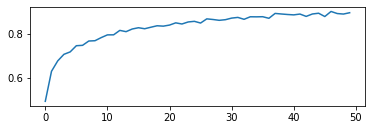

In [ ]:
'''
Using Bottleneck Features for Multi-Class Classification in Keras
We use this technique to build powerful (high accuracy without overfitting) Image Classification systems with small
amount of training data.

The code was tested on Python 3.5, with the following library versions,
Keras 2.0.6
TensorFlow 1.2.1
OpenCV 3.2.0
'''
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math
import cv2

# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '/content/datasetaftersplit/train/'
validation_data_dir = '/content/datasetaftersplit/val/'

# number of epochs to train top model
epochs = 50
# batch size used by flow_from_directory and predict_generator
batch_size = 16


def save_bottlebeck_features():
    # build the VGG19 network
    model = applications.VGG19(include_top=False, weights='imagenet')

    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    print(len(generator.filenames))
    print(generator.class_indices)
    print(len(generator.class_indices))

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(
        generator, predict_size_train)

    np.save('bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        generator, predict_size_validation)

    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)


def train_top_model():
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('bottleneck_features_validation.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_acccuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def predict():
    # load the class_indices saved in the earlier step
    class_dictionary = np.load('class_indices.npy').item()

    num_classes = len(class_dictionary)

    # add the path to your test image below
    image_path = 'path/to/your/test_image'

    orig = cv2.imread(image_path)

    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # important! otherwise the predictions will be '0'
    image = image / 255

    image = np.expand_dims(image, axis=0)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the top model to get the final
    # classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    probabilities = model.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    # get the prediction label
    print("Image ID: {}, Label: {}".format(inID, label))

    # display the predictions with the image
    cv2.putText(orig, "Predicted: {}".format(label), (10, 30),
                cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)

    cv2.imshow("Classification", orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


save_bottlebeck_features()
train_top_model()
predict()

cv2.destroyAllWindows()



---


SOURCE:

http://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html